# 第5部　線形ガウス状態空間モデル

## 第5章　基本構造時系列モデル

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### forループを用いたローカルレベルモデルのシミュレーション

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
mu_cumsum = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

In [4]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
mu_for = np.zeros(sim_size)
mu_for[0] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

for t in range(1, sim_size):
    mu_for[t] = mu_for[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

In [5]:
# 結果は一致する
all(mu_cumsum == mu_for)

True

### 平滑化トレンドモデルのシミュレーション

#### シミュレーションの実施

In [6]:
# 乱数の種
np.random.seed(1)

# ドリフト成分
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 水準成分
mu_smooth = np.zeros(sim_size)

In [7]:
# シミュレーション
for t in range(2, sim_size):
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]
    mu_smooth[t] = mu_smooth[t - 1] + delta[t - 1]

# 観測値
y_smooth = mu_smooth + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [8]:
# DataFrameにまとめる
smooth_df = pd.DataFrame(
    {'delta':delta, 'mu': mu_smooth, 'y':y_smooth},
    index=pd.date_range(start='2000-01-01', periods=sim_size, freq='MS')
)

# 結果の確認
print(smooth_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000  10.470481
2000-02-01  1.624345  0.000000  -6.706928
2000-03-01  1.012589  1.624345  19.991961


#### シミュレーション結果の可視化

<Axes: >

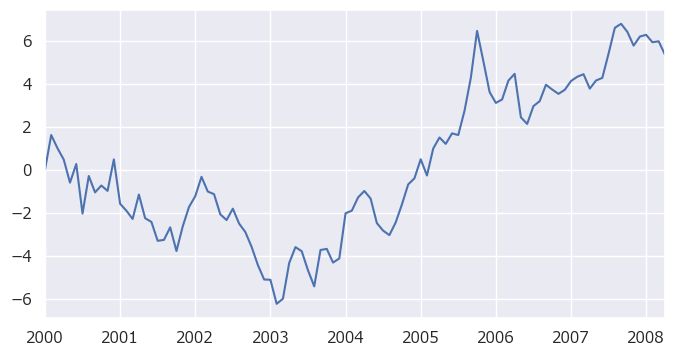

In [9]:
# ドリフト成分の可視化
smooth_df['delta'].plot()

<Axes: >

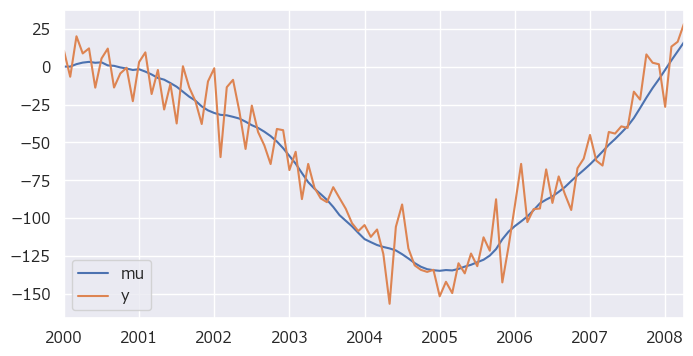

In [10]:
# 水準成分と観測値の可視化
smooth_df[['mu', 'y']].plot()

In [11]:
# 水準成分は、正規ホワイトノイズの2階累積和をとったものとみなせる
# これが「2階差分」の由来
np.random.seed(1)
cumsum2 = np.cumsum(
    np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))
)

all(cumsum2[0:98] == mu_smooth[2:])

True

### 平滑化トレンドモデルの推定

#### 推定

In [12]:
# 平滑化トレンドモデル
mod_smooth = tsa.UnobservedComponents(
    smooth_df['y'],          # 対象データ
    level='smooth trend'     # 平滑化トレンド
)

# 最尤法によるパラメータの推定
res_smooth = mod_smooth.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=2000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.165624
         Iterations: 52
         Function evaluations: 103


In [13]:
# 推定された分散の平方根
np.sqrt(res_smooth.params)

sigma2.irregular    14.138599
sigma2.trend         0.719196
dtype: float64

#### すべての成分をまとめて可視化

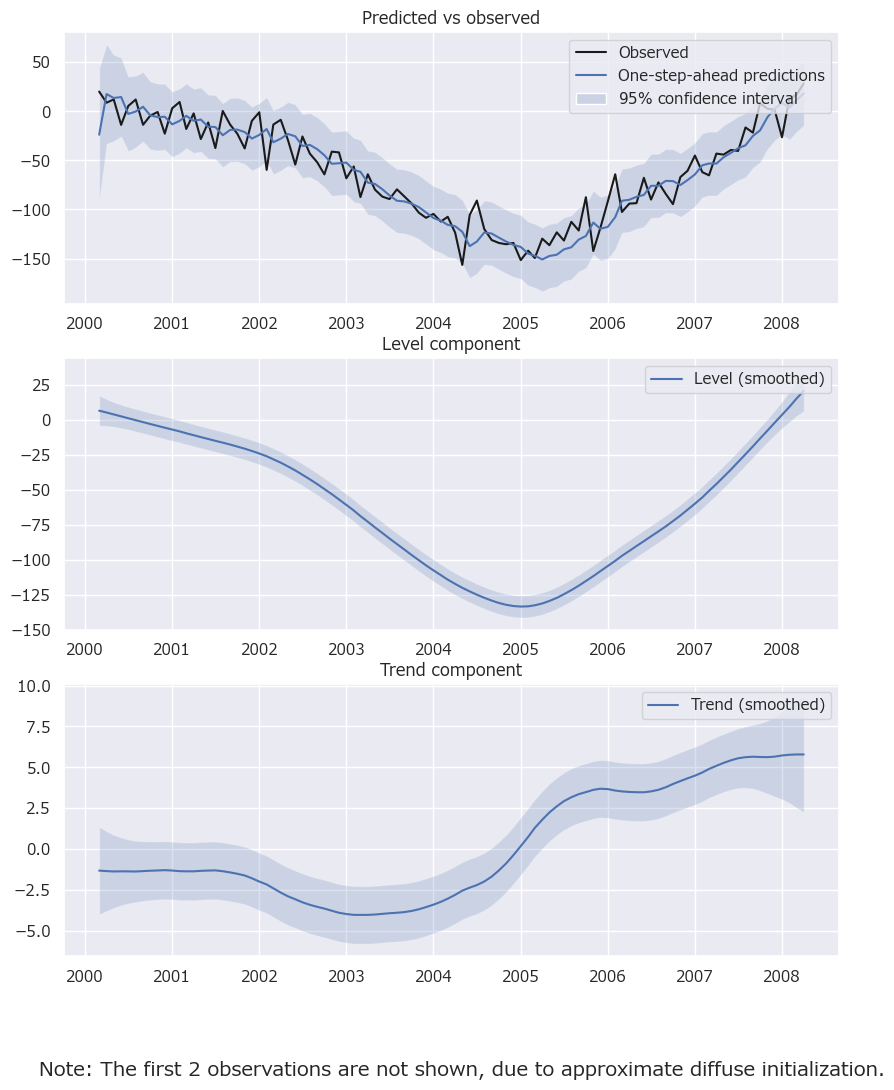

In [14]:
# 推定された状態・トレンド・季節の影響の描画
fig = res_smooth.plot_components(figsize=(10, 12))

#### ドリフト成分の可視化

(-10.0, 10.0)

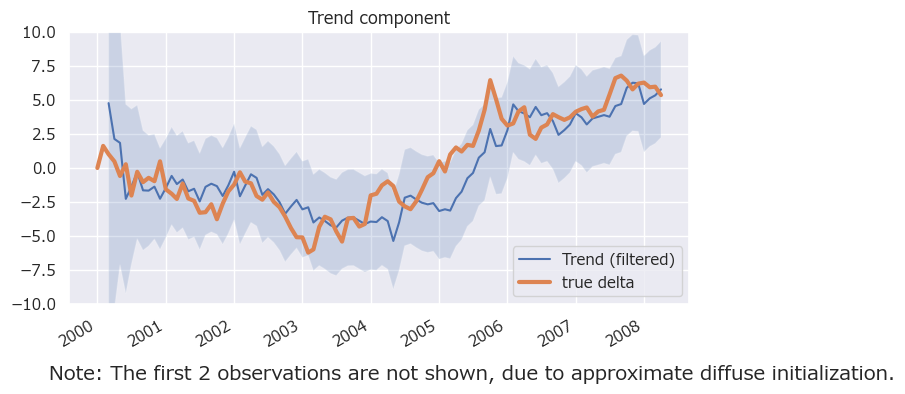

In [15]:
# 個別のグラフ
# ドリフト成分のフィルタ化推定量のみを図示
fig = res_smooth.plot_components(
    which='filtered',  # フィルタ化推定量を対象にする
    observed=False,    # 観測値は不要
    level=False,       # 水準成分は不要
    trend=True,        # ドリフト成分のみ必要
    seasonal=False,    # 季節成分は不要
    figsize=(8, 4)     # グラフの大きさ
)

# 正しいドリフト成分
smooth_df.delta.plot(linewidth=3, label='true delta')

# 凡例
plt.legend()

# Y軸の範囲を-10から10に変更
plt.ylim(-10, 10)

#### 個別の成分の取得

In [16]:
# ドリフト成分の取得

# フィルタ化推定量
print(res_smooth.trend['filtered'][:4])

# 平滑化推定量
print(res_smooth.trend['smoothed'][:4])

[  0.         -17.16845309   4.77003853   2.13530599]
[-1.29717419 -1.29385304 -1.32497374 -1.35586851]


(-10.0, 10.0)

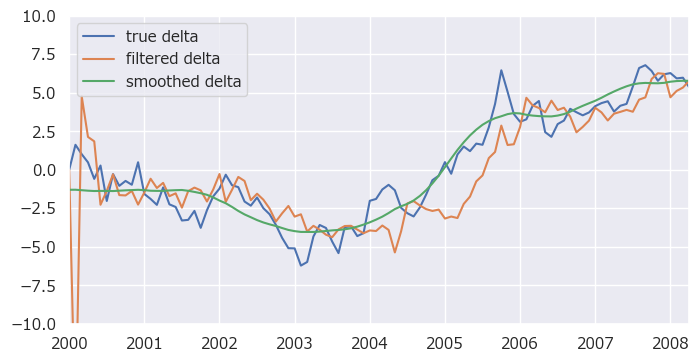

In [17]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true delta': smooth_df.delta,
    'filtered delta': res_smooth.trend['filtered'],
    'smoothed delta': res_smooth.trend['smoothed']
})

# 可視化
plot_df.plot()

# Y軸の範囲を-10から10に変更
plt.ylim(-10, 10)

#### 水準成分の可視化

<Axes: >

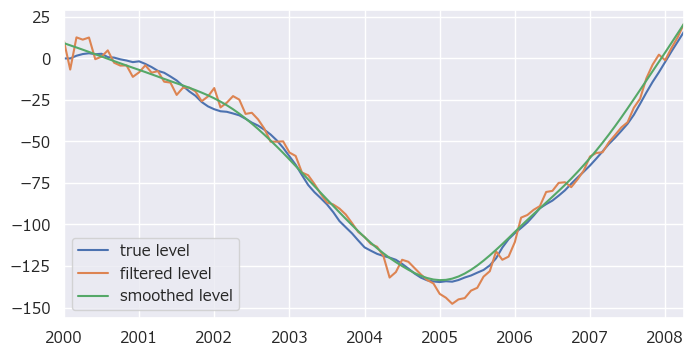

In [18]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true level': smooth_df.mu,
    'filtered level': res_smooth.level['filtered'],
    'smoothed level': res_smooth.level['smoothed']
})

# 可視化
plot_df.plot()

### ローカル線系トレンドモデルのシミュレーション

In [19]:
# 乱数の種
np.random.seed(1)

# ドリフト成分
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 水準成分
mu_trend = np.zeros(sim_size)

In [20]:
# シミュレーション
for t in range(2, sim_size):
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]
    mu_trend[t] = mu_trend[t - 1] + delta[t] + \
                  stats.norm.rvs(loc=0, scale=10, size=1)[0]

# 観測値
y_trend = mu_trend + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [21]:
# DataFrameにまとめる
trend_df = pd.DataFrame(
    {'delta':delta, 'mu': mu_trend, 'y':y_trend},
    index=pd.date_range(start='2000-01-01', periods=sim_size, freq='MS')
)

# 結果の確認
print(trend_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000   6.304233
2000-02-01  1.624345  0.000000  12.164275
2000-03-01  1.012589 -4.269129  11.397503


<Axes: >

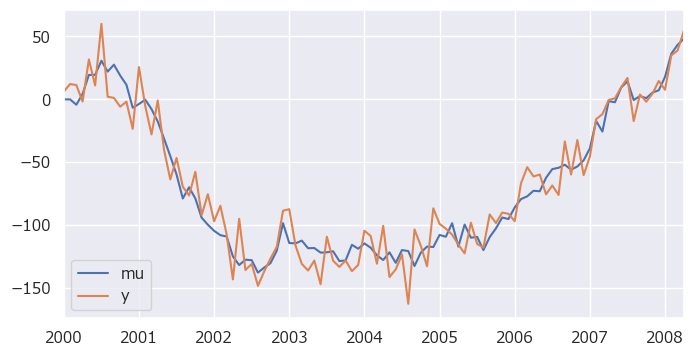

In [22]:
# 水準成分と観測値の可視化
trend_df[['mu', 'y']].plot()

### ローカル線系トレンドモデルの推定

#### 推定

In [23]:
# ローカル線形トレンドモデル
mod_trend = tsa.UnobservedComponents(
    trend_df['y'],                 # 対象データ
    level='local linear trend'     # ローカル線形トレンド
)

# 最尤法によるパラメータの推定
res_trend = mod_trend.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=2000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.332766
         Iterations: 129
         Function evaluations: 239


In [24]:
# 参考：推定された分散の平方根
np.sqrt(res_trend.params)

sigma2.irregular    14.860495
sigma2.level         7.109954
sigma2.trend         0.731254
dtype: float64

#### 可視化

<Axes: >

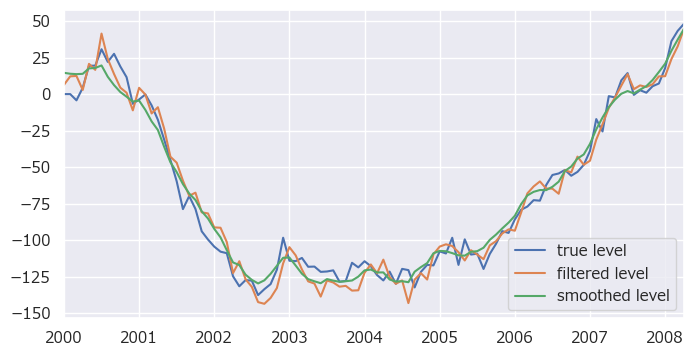

In [25]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true level': trend_df.mu,
    'filtered level': res_trend.level['filtered'],
    'smoothed level': res_trend.level['smoothed']
})

# 可視化
plot_df.plot()

### 三角関数を用いた季節成分

#### 季節成分のシミュレーション

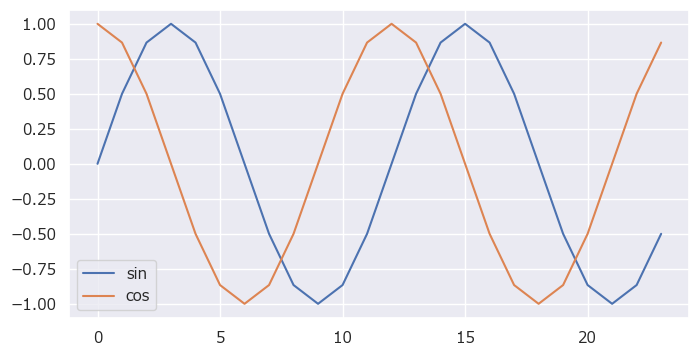

In [26]:
# 単純な三角関数

m = 12             # 周期
sin = np.zeros(24) # sin波
cos = np.zeros(24) # cos波

lambda_1 = 2 * np.pi * 1 / m

for t in range(0, 24):
    sin[t] = np.sin(lambda_1 * t)
    cos[t] = np.cos(lambda_1 * t)

# 折れ線グラフを描く
plt.plot(sin, label='sin')
plt.plot(cos, label='cos')
plt.legend()

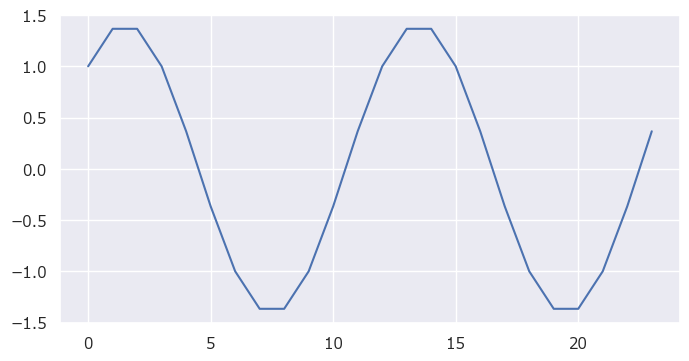

In [27]:
# sin波とcos波の和
gamma = np.zeros(24)

for t in range(0, 24):
    gamma[t] = np.sin(lambda_1 * t) + np.cos(lambda_1 * t)

# 折れ線グラフを描く
plt.plot(gamma)

In [28]:
# sin波とcos波の和
gamma_1      = np.zeros(24)
gamma_1_star = np.zeros(24)

gamma_1[0]      = 1
gamma_1_star[0] = 1

for t in range(1, 24):
    gamma_1[t]      =  gamma_1[t - 1] * np.cos(lambda_1) + \
                       gamma_1_star[t - 1] * np.sin(lambda_1)
    gamma_1_star[t] = -gamma_1[t - 1] * np.sin(lambda_1) + \
                       gamma_1_star[t - 1] * np.cos(lambda_1)

# 単純なsin波とcos波の和とほぼ同じ結果になる
np.sum((gamma - gamma_1) ** 2)

2.5200408136318104e-29

In [29]:
# sin波とcos波の重みつきの和
gamma_1_weight = np.zeros(24)

for t in range(0, 24):
    gamma_1_weight[t] = -1 * np.sin(lambda_1 * t) + 1 * np.cos(lambda_1 * t)

In [30]:
# 6か月周期の場合
lambda_2 = 2 * np.pi * 2 / m

gamma_2 = np.zeros(24)

for t in range(0, 24):
    gamma_2[t] = np.sin(lambda_2 * t) + np.cos(lambda_2 * t)

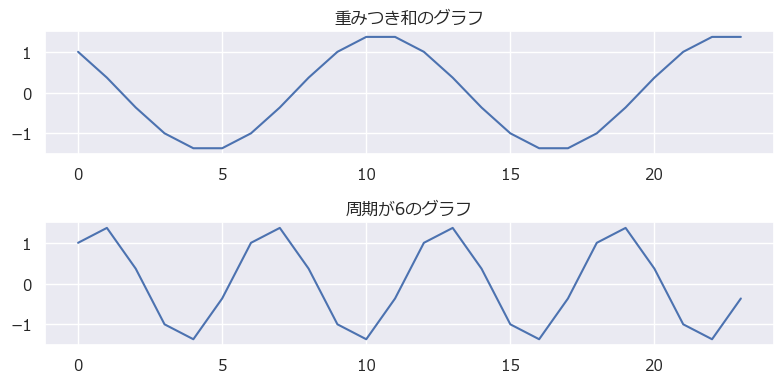

In [31]:
# 可視化
fig, ax = plt.subplots(nrows=2, tight_layout=True)

ax[0].set_title('重みつき和のグラフ')
ax[0].plot(gamma_1_weight)

ax[1].set_title('周期が6のグラフ')
ax[1].plot(gamma_2)

### 基本構造時系列モデルのシミュレーション

In [32]:
# 乱数の種
np.random.seed(1)

# 季節成分
s = np.zeros(sim_size)

# 季節成分の初期値
s_12 = np.array([-30, -75, -45, -15,  5,  30,  
                  40,  60,  25,  15,   5, -15])

In [33]:
# 1月の季節成分の再現
print('2月から12月の季節成分', s_12[1:12])

print('1月の季節成分の再現  ', 0 - np.sum(s_12[1:12]))

2月から12月の季節成分 [-75 -45 -15   5  30  40  60  25  15   5 -15]
1月の季節成分の再現   -30


In [34]:
# 最初の12時点において、季節成分の初期値を代入
s[0:12] = s_12

# 季節成分のシミュレーション
for t in range(12, sim_size):
    s[t] = stats.norm.rvs(loc=0, scale=2, size=1)[0] - \
           np.sum(s[(t - 11):t])

# 状態
alpha = mu_trend + s

# 観測値
y_bsts = alpha + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [35]:
# DataFrameにまとめる
bsts_df = pd.DataFrame(
    {'delta':delta, 'mu': mu_trend, 's':s, 'alpha':alpha, 'y':y_bsts},
    index=pd.date_range(start='2000-01-01', periods=sim_size, freq='MS')
)

# 結果の確認
print(bsts_df.head(3))

               delta        mu     s      alpha          y
2000-01-01  0.000000  0.000000 -30.0 -30.000000 -28.172681
2000-02-01  1.624345  0.000000 -75.0 -75.000000 -58.057741
2000-03-01  1.012589 -4.269129 -45.0 -49.269129 -31.285360


<Axes: >

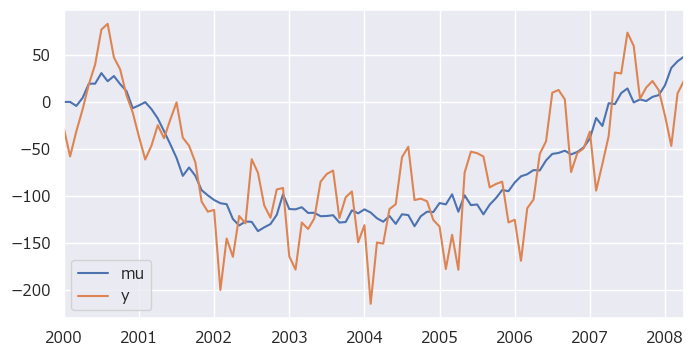

In [36]:
# 水準成分と観測値の可視化
bsts_df[['mu', 'y']].plot()

### 基本構造時系列モデルの推定

#### 推定

In [37]:
# 季節変動ありのローカル線形トレンドモデル
mod_bsts = tsa.UnobservedComponents(
    bsts_df['y'],                   # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    seasonal=12
)

# 最尤法によるパラメータの推定
res_bsts = mod_bsts.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=2000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.001858
         Iterations: 263
         Function evaluations: 464


In [38]:
# 参考：推定された分散の平方根
np.sqrt(res_bsts.params)

sigma2.irregular    15.708394
sigma2.level         7.388746
sigma2.trend         0.964637
sigma2.seasonal      0.000004
dtype: float64

#### 可視化

<Axes: >

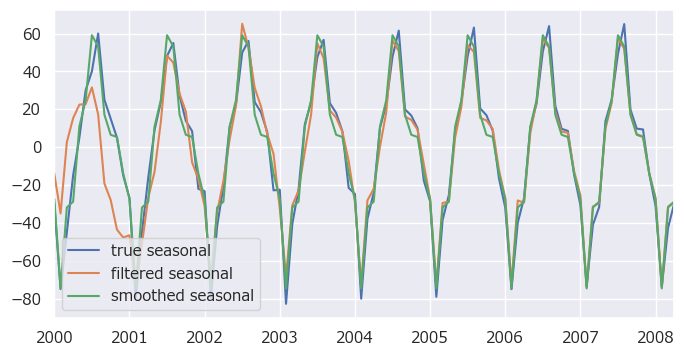

In [39]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true seasonal': bsts_df['s'],
    'filtered seasonal': res_bsts.seasonal['filtered'],
    'smoothed seasonal': res_bsts.seasonal['smoothed']
})

# 可視化
plot_df.plot()

<Axes: >

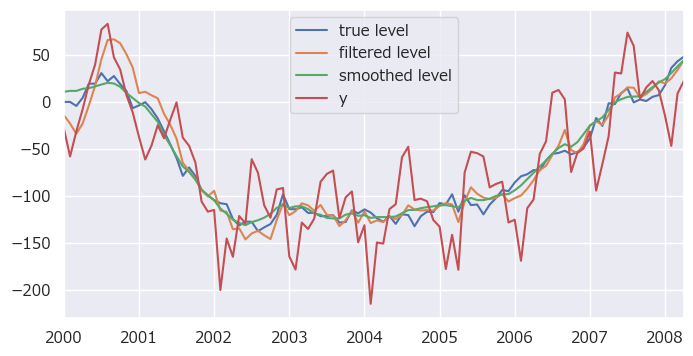

In [40]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true level': bsts_df['mu'],
    'filtered level': res_bsts.level['filtered'],
    'smoothed level': res_bsts.level['smoothed'],
    'y':bsts_df['y']
})

# 可視化
plot_df.plot()

<Axes: >

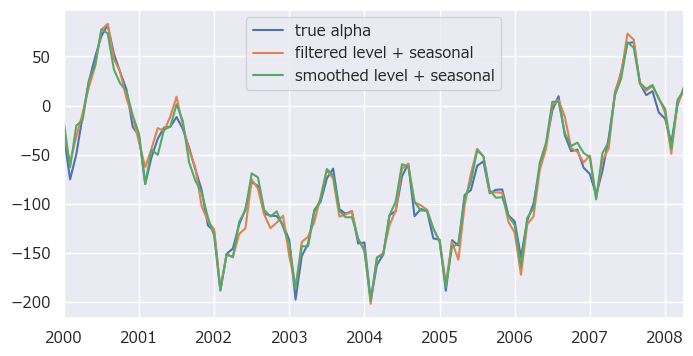

In [41]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true alpha': bsts_df['alpha'],
    'filtered level + seasonal': res_bsts.level['filtered'] + \
                                 res_bsts.seasonal['filtered'],
    'smoothed level + seasonal': res_bsts.level['smoothed'] + \
                                 res_bsts.seasonal['smoothed']
})

# 可視化
plot_df.plot()

#### 三角関数を用いた季節成分の利用

In [42]:
# 三角関数を用いた季節成分を有するモデル
mod_bsts_tri = tsa.UnobservedComponents(
    bsts_df['y'],                   # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    freq_seasonal=[{'period':12, 'harmonics':1}]
)

# 最尤法によるパラメータの推定
res_bsts_tri = mod_bsts_tri.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=2000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.607108
         Iterations: 266
         Function evaluations: 459


In [43]:
# 参考：推定された分散の平方根
np.sqrt(res_bsts_tri.params)

sigma2.irregular              21.448571
sigma2.level                   7.418416
sigma2.trend                   0.856370
sigma2.freq_seasonal_12(1)     0.000013
dtype: float64

<Axes: >

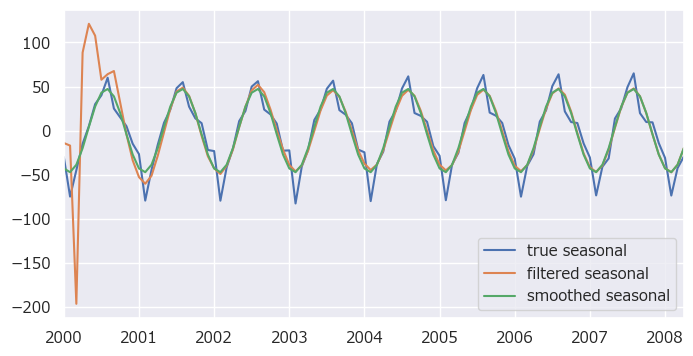

In [44]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true seasonal': bsts_df.s,
    'filtered seasonal': res_bsts_tri.freq_seasonal[0]['filtered'],
    'smoothed seasonal': res_bsts_tri.freq_seasonal[0]['smoothed']
})

# 可視化
plot_df.plot()

In [45]:
# 三角関数を用いた複雑な季節成分を有するモデル
mod_bsts_tri_6 = tsa.UnobservedComponents(
    bsts_df['y'],                   # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    freq_seasonal=[{'period':12, 'harmonics':6}]
)

# 最尤法によるパラメータの推定
res_bsts_tri_6 = mod_bsts_tri_6.fit(
    method='nm',              # Nelder-Mead法を使う
    maxiter=2000              # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 3.957482
         Iterations: 326
         Function evaluations: 550


<Axes: >

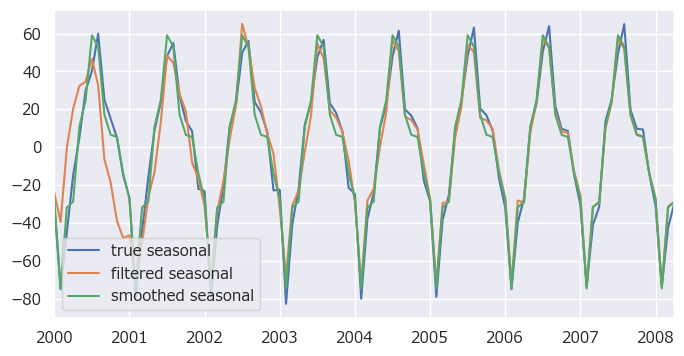

In [46]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'true seasonal': bsts_df.s,
    'filtered seasonal': res_bsts_tri_6.freq_seasonal[0]['filtered'],
    'smoothed seasonal': res_bsts_tri_6.freq_seasonal[0]['smoothed']
})

# 可視化
plot_df.plot()

### モデルの評価

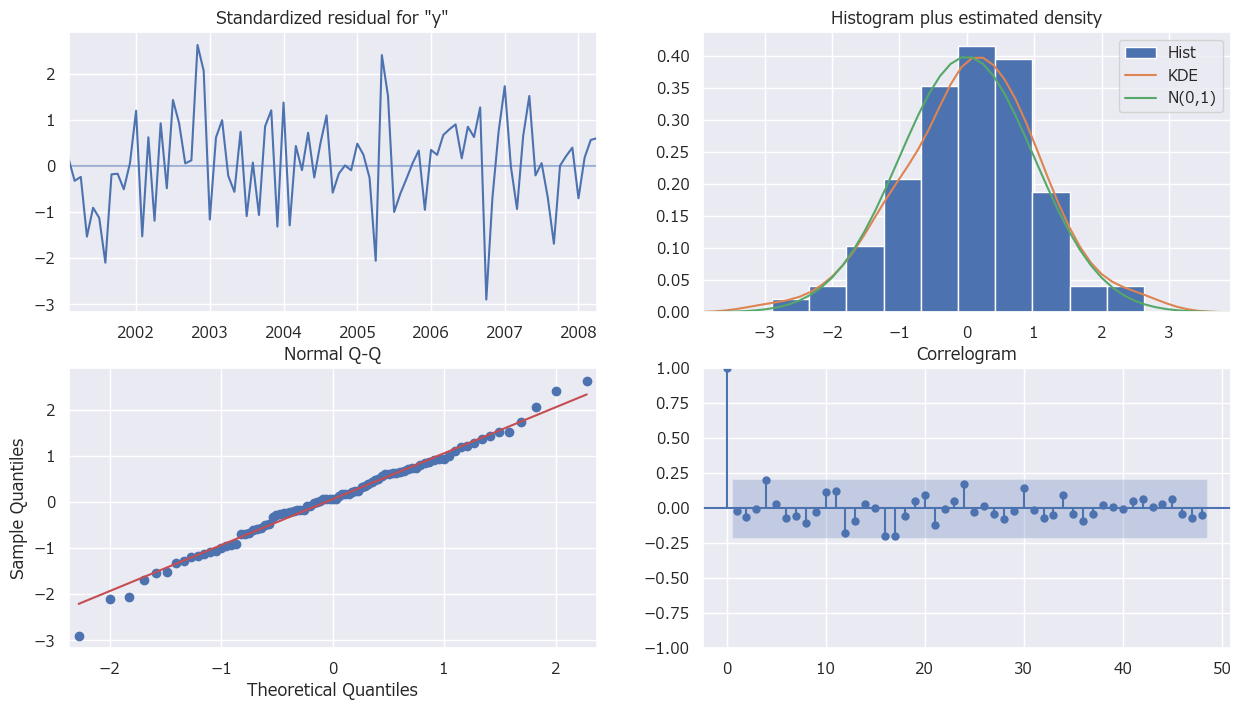

In [47]:
# 残差のチェック
_ = res_bsts.plot_diagnostics(lags=48, figsize=(15, 8))

In [48]:
# 参考：残差の正規性の検定
res_bsts.test_normality(method='jarquebera')

array([[ 0.76824712,  0.68104727, -0.15290462,
         3.34410893]])

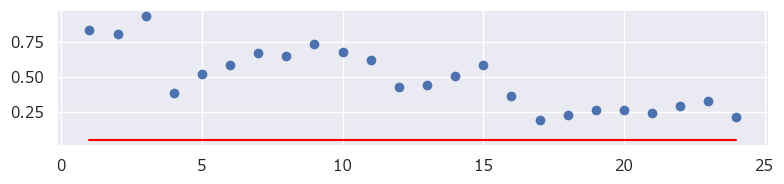

In [49]:
# 参考：残差の自己相関の検定
# 1時点前から48時点前まで、1つずつ最大次数をずらして、24回検定を行う
res_test = res_bsts.test_serial_correlation(
    method='ljungbox', lags=24)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# p値のグラフを描画
ax.scatter(np.arange(1,25), res_test[0][1])

# 高さ0.05の位置に赤線を引く
ax.plot(np.arange(1,25), np.tile(0.05, 24), color='red')

### 予測

In [50]:
# 予測
res_bsts.forecast(2)

2008-05-01    60.081789
2008-06-01    78.927665
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: >

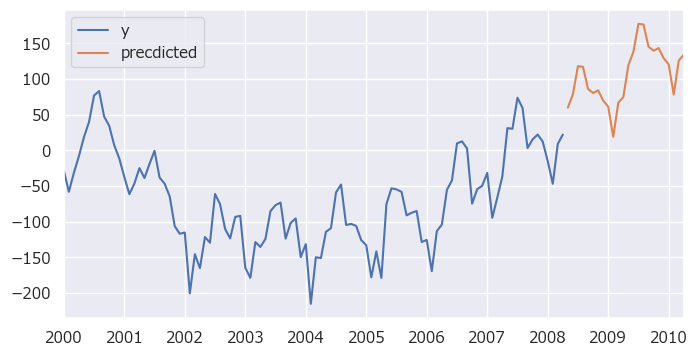

In [51]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame({
    'y': bsts_df['y'],
    'precdicted':res_bsts.forecast(24)
})

# 可視化
plot_df.plot()